<a href="https://colab.research.google.com/github/Thiraput01/NLP-sys/blob/main/Week%203/HW3_1_Key_Value_Attention_for_Thai_Karaoke_MT_to_student_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
!pip install lightning wandb
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 25.6 MB/s eta 0:00:00
--2025-01-22 05:47:21--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2025-01-22 05:47:22--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserco

In [271]:
!wandb login

wandb: Currently logged in as: thiraputball (thiraputball-chulalongkorn-university). Use `wandb login --relogin` to force relogin


In [272]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [273]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2025-01-22 07:50:53--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv.2’

mp_name_th_en.csv.2 100%[===================>] 316.80K  --.-KB/s    in 0.03s   

2025-01-22 07:50:54 (9.57 MB/s) - ‘mp_name_th_en.csv.2’ saved [324399/324399]



In [274]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [275]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [276]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

There are 10887 lines and 65 unique characters in your input data.


In [277]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [278]:
sorted_chars= sorted(input_chars)
sorted_output_chars= sorted(output_chars)
sorted_chars.insert(0,"</s>")
sorted_output_chars.insert(0,"</s>")
sorted_output_chars.append("<EOS>")

# Quick implementation of character tokenizer
# create a mapping from characters to integers
input_stoi = { ch:i for i,ch in enumerate(sorted_chars) }
input_itos = { i:ch for i,ch in enumerate(sorted_chars) }
input_encode = lambda s: [input_stoi[c] for c in s] # encoder: take a string, output a list of integers
input_decode = lambda l: ''.join([input_itos[i] for i in l]) # decoder: take a list of integers, output a string


output_stoi = { ch:i for i,ch in enumerate(sorted_output_chars) }
output_itos = { i:ch for i,ch in enumerate(sorted_output_chars) }
output_encode = lambda s: [output_stoi[c] for c in s] # encoder: take a string, output a list of integers
output_decode = lambda l: ''.join([output_itos[i] for i in l]) # decoder: take a list of integers, output a string

In [279]:
print(input_encode("ไกรสีห์"))
print(input_decode(input_encode("ไกรสีห์")))

[58, 2, 34, 39, 49, 40, 64]
ไกรสีห์


In [280]:
print(input_stoi)
print(output_stoi)

{'</s>': 0, ' ': 1, 'ก': 2, 'ข': 3, 'ค': 4, 'ฆ': 5, 'ง': 6, 'จ': 7, 'ฉ': 8, 'ช': 9, 'ซ': 10, 'ฌ': 11, 'ญ': 12, 'ฎ': 13, 'ฏ': 14, 'ฐ': 15, 'ฑ': 16, 'ฒ': 17, 'ณ': 18, 'ด': 19, 'ต': 20, 'ถ': 21, 'ท': 22, 'ธ': 23, 'น': 24, 'บ': 25, 'ป': 26, 'ผ': 27, 'ฝ': 28, 'พ': 29, 'ฟ': 30, 'ภ': 31, 'ม': 32, 'ย': 33, 'ร': 34, 'ล': 35, 'ว': 36, 'ศ': 37, 'ษ': 38, 'ส': 39, 'ห': 40, 'ฬ': 41, 'อ': 42, 'ฮ': 43, 'ะ': 44, 'ั': 45, 'า': 46, 'ำ': 47, 'ิ': 48, 'ี': 49, 'ึ': 50, 'ื': 51, 'ุ': 52, 'ู': 53, 'เ': 54, 'แ': 55, 'โ': 56, 'ใ': 57, 'ไ': 58, '็': 59, '่': 60, '้': 61, '๊': 62, '๋': 63, '์': 64}
{'</s>': 0, '-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'w': 21, 'y': 22, '<EOS>': 23}


In [281]:
X = []
for line in name_th:
    line = [l for l in line] #change from string to list
    X.append(torch.tensor(input_encode(line)))
Y = []
for line in name_en:
    line = [l for l in line] #change from string to list
    Y.append(torch.tensor(output_encode(line)))

X = nn.utils.rnn.pad_sequence(X, batch_first = True)
Y = nn.utils.rnn.pad_sequence(Y, batch_first = True)

In [282]:
X.long()

tensor([[58,  2, 34,  ...,  0,  0,  0],
        [29, 45,  9,  ...,  0,  0,  0],
        [23, 49, 34,  ...,  0,  0,  0],
        ...,
        [ 2, 32, 35,  ...,  0,  0,  0],
        [31, 36, 45,  ...,  0,  0,  0],
        [29, 45, 17,  ...,  0,  0,  0]])

In [283]:
X.shape, Y.shape

(torch.Size([10887, 20]), torch.Size([10887, 19]))

In [284]:
input_decode(X[0].tolist())

'ไกรสีห์</s></s></s></s></s></s></s></s></s></s></s></s></s>'

In [285]:
output_decode(Y[0].tolist())

'kraisi</s></s></s></s></s></s></s></s></s></s></s></s></s>'

In [286]:
from torch.utils.data import Dataset, DataLoader

In [287]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    self.encoded = X.long()
    self.label = y.long()

  def __getitem__(self, idx):
    return {"x" :self.encoded[idx], "y":self.label[idx]}

  def __len__(self):
    return len(self.encoded)

In [288]:
class NameDataModule(L.LightningDataModule):

  def __init__(self, train_data, y, batch_size=32, num_workers=0):
      super().__init__()
      self.train_data = train_data
      self.y = y
      self.batch_size = batch_size
      self.num_workers = num_workers


  def setup(self, stage: str):
    pass

  def collate_fn(self, batch):
      one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
      return {"x": one_hot_x.float(), "y": torch.stack([b["y"] for b in batch])}

  def train_dataloader(self):
    train_dataset = NameDataset(self.train_data, self.y)
    return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn, num_workers=self.num_workers)


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [289]:
def one_step_attention(h, s_prev, linear_1, linear_2):
    #h.shape = batch, seq, hidden_dim
    #s_prev.shape = batch, hidden_dim
    #Split into Key-Value
    key, value = torch.split(h, h.shape[-1] // 2, dim=-1)             # (batch, seq, hidden_dim / 2)
    #do concat with s_prev.
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful
    s_prev = s_prev.unsqueeze(1).repeat(1, key.shape[1], 1)           # (batch, seq, hidden_dim)
    concat = torch.cat((key, s_prev), dim=-1)                         # (batch, seq, 3/2 hidden_dim)

    #Attention function###
    # use layer(s) from your model to calculate attention_scores and then softmax
    e = F.tanh(linear_1(concat))                                      # (batch, seq, 3/2 hidden_dim) --linear_1--> (batch, seq, hidden_dim)
    energies = F.relu(linear_2(e))                                    # (batch, seq, 1)
    # calculate attention_scores (softmax)
    attention_scores = F.softmax(energies, dim=1)                     # (batch, seq, 1)
    # calculate a context vector
    temp = torch.mul(attention_scores, value)                         # (batch seq, hidden_dim / 2)
    context = torch.sum(temp,dim=1)                                   # (batch, hidden_dim / 2)


    return context, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [299]:
input_vocab = input_stoi
output_vocab = output_stoi

In [300]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

In [301]:
from os import lseek
class AttentionModel(L.LightningModule):
    def __init__(self):

        super().__init__()
        self.n_h = 32 #hidden dimensions for encoder
        self.n_s = 64 #hidden dimensions for decoder

        self.learning_rate = learning_rate
        self.criterion = criterion

        #encoder can be any RNN of your choice
        bidirection = True
        self.lstm = nn.LSTM(len(input_stoi), self.n_h, bidirectional=True, batch_first=True)

        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s // 2, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_vocab))
        #attention
        self.fc1 = nn.Linear(self.n_h*2*3//2, self.n_h)
        self.fc2 = nn.Linear(self.n_h, 1)


    def forward(self, src, return_attention=True): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src)

        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out, len(output_vocab))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):

            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.fc1, self.fc2)

            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))

            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)

            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

            attention_scores.append(attention_score)

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(output_vocab))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch['x']
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            print("".join(output_decode(pred.cpu().numpy())))
            # print("".join(output_vocab.lookup_tokens(pred.cpu().numpy())))
            # 'dict' object has no attribute 'lookup_tokens'
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [302]:
model = AttentionModel()

In [303]:
data_module = NameDataModule(X, Y)

In [304]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention")

In [305]:
trainer = L.Trainer(
    max_epochs=100,
    logger=wandb_logger
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [306]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | train
1 | lstm              | LSTM             | 25.3 K | train
2 | decoder_lstm_cell | LSTMCell         | 25.1 K | train
3 | output_layer      | Linear           | 1.6 K  | train
4 | fc1               | Linear           | 3.1 K  | train
5 | fc2               | Linear           | 33     | train
---------------------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.221     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type             | Params | Mode 
-----------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [307]:
import wandb
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇█
train_loss,█▆▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
epoch,99
train_loss,0.03233
trainer/global_step,34099


# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [126]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ']

predict_data = []
for line in EXAMPLES:
    line = [l for l in line]
    predict_data.append(torch.tensor(input_encode(line)))

def collate_fn(batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
    return {"x": one_hot_x.float()}

predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first = True)
predict_dataset = NameDataset(predict_data, torch.tensor([torch.tensor(0)]*len(predict_data)))
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0)

In [233]:
tmp = next(iter(predict_loader))
tmp['x'].shape
# (batch, seq_len, vocab)

torch.Size([1, 8, 65])

In [308]:
model = AttentionModel.load_from_checkpoint("/content/hw3.1_attention/bc62mbiw/checkpoints/epoch=99-step=34100.ckpt")
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(65, 32, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(32, 64)
  (output_layer): Linear(in_features=64, out_features=24, bias=True)
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [309]:
output = trainer.predict(model, predict_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

prayutthap</s></s></s></s></s></s></s></s></s>
somchai</s></s></s></s></s></s></s></s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s>
newin</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s></s></s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s></s></s></s></s>


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [310]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [361]:
prediction, attention_scores = zip(*output)

In [362]:
prediction[0].shape

torch.Size([1, 19])

In [363]:
attention_scores[0][0].shape

torch.Size([1, 8, 1])

In [364]:
attn_viz = torch.stack(attention_scores[0]).squeeze().cpu().numpy()
attn_viz = attn_viz.transpose(1,0)
output_text = "".join(output_decode(c) for c in prediction[0].cpu().numpy())
output_text = list(output_text.replace('</s>', ""))
output_text.append('</s>')

In [365]:
xlabels = [c for c in EXAMPLES[0]]
xlabels.append('<PAD>')

In [366]:
print(f"attn_viz.shape: {attn_viz.shape}")
print(f"xlabels: {xlabels} | len: {len(xlabels)}")
print(f"output_text: {output_text} | len: {len(output_text)}")

attn_viz.shape: (8, 19)
xlabels: ['ป', 'ร', 'ะ', 'ย', 'ุ', 'ท', 'ธ', '<PAD>'] | len: 8
output_text: ['p', 'r', 'a', 'y', 'u', 't', 't', 'h', 'a', 'p', '</s>'] | len: 11


In [372]:
attn_viz = attn_viz[:, :len(output_text)]
attn_viz = attn_viz.T

In [373]:
print(f"attn_viz.shape: {attn_viz.shape}")
print(f"xlabels: {xlabels} | len: {len(xlabels)}")
print(f"output_text: {output_text} | len: {len(output_text)}")

attn_viz.shape: (11, 8)
xlabels: ['ป', 'ร', 'ะ', 'ย', 'ุ', 'ท', 'ธ', '<PAD>'] | len: 8
output_text: ['p', 'r', 'a', 'y', 'u', 't', 't', 'h', 'a', 'p', '</s>'] | len: 11


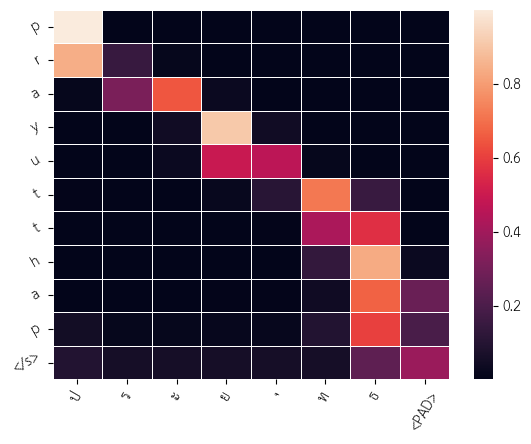

In [374]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(xlabels,rotation=60)
plt.show()

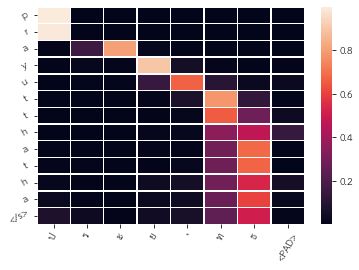

In [ ]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(xlabels,rotation=60)
plt.show()